Let's try to understand the energy landscape of the dipolar droplets. The plots here might help to illustrate why the search for critical atom number is so difficult. 

Conclusion: when using the typical functional minimization method from scipy, it might occur that during the optimization the optimizer ends up in a region where the energy diverges. Also, the region of interest can be very tiny so one should try many diferent initial conditions in order to end up in a correct point. 

I made a little animation at the end, don't miss it out! 😊

# Import dependencies

In [1]:
import numpy as np
from scipy.optimize import curve_fit

In [2]:
from estimate_nc.estimate_nc import en_per_particle

In [3]:
r_0 = 387.6   # https://www.wolframalpha.com/input?i=%28162Dy+mass%29+*+%28mu_0%29+*+%289.93+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+%2F+%28bohr+radius%29

In [4]:
data = np.loadtxt("./results/dy-df/functionals_E_N.dat")
# the header is: a_s  n_c_best_possible_fit  rho_min_x  rho_max_x  alpha  alpha_opt  beta  gamma  min_energy  
# read all data
a_s = data[:,0]
n_c_best_possible_fit = data[:,1]
rho_min_x = data[:,2]
rho_max_x = data[:,3]
alpha = data[:,4]
alpha_opt = data[:,5]
beta = data[:,6]
gamma = data[:,7]

# Take only the data where rho_min_x is smaller than 0.7, and rho_max_x is larger than 2.0
indices = np.where((rho_min_x < 0.7) & (rho_min_x > 0.4) & (rho_max_x > 1.5) & (rho_max_x < 2.5))
a_s = a_s[indices]
n_c_best_possible_fit = n_c_best_possible_fit[indices]
rho_min_x = rho_min_x[indices]
rho_max_x = rho_max_x[indices]
alpha = alpha[indices]
alpha_opt = alpha_opt[indices]
beta = beta[indices]
gamma = gamma[indices]


# On the same plot, plot the error bar for each a_s
a_s_unique = np.unique(a_s)
average = np.zeros(len(a_s_unique))
std = np.zeros(len(a_s_unique))
for i in range(len(a_s_unique)):
    average[i] = np.average(beta[a_s==a_s_unique[i]])
    std[i] = np.std(beta[a_s==a_s_unique[i]])
# Make a linear fit of the average beta vs a_s
def func_beta(x, a, b):
    return a*x + b
popt_beta, pcov = curve_fit(func_beta, a_s_unique, average)

a_s_unique = np.unique(a_s)
average = np.zeros(len(a_s_unique))
std = np.zeros(len(a_s_unique))
for i in range(len(a_s_unique)):
    average[i] = np.average(gamma[a_s==a_s_unique[i]])
    std[i] = np.std(gamma[a_s==a_s_unique[i]])
# Make a linear fit of the average gamma vs a_s
def func_gamma(x, a, b):
    return a*x + b
popt_gamma, pcov = curve_fit(func_gamma, a_s_unique, average)


In [5]:
# Using all the code above, make an animation of the energy landscape as a function of the number of particles. Use nparticles = 1.77E+03, 1.6E+03, 1.5E+03, 1.47E+03, 1.4E+03

import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML



nparticles_arr = 10**np.linspace(np.log10(1.2E+03), np.log10(4E+03), 50)
# Make nparticles_arr go from larger to smaller
nparticles_arr = nparticles_arr[::-1]


a_s = 90
from estimate_nc.estimate_nc import *
alpha = 2*np.pi*(a_s/r_0) # * (1 - 1 / (3*(a_s / r_0)))
out = estimate_nc(alpha,func_beta(a_s, *popt_beta), func_gamma(a_s, *popt_gamma), based_on="size", verbose=False)
out

(2338.4077695809847, 1.1509479566198054e-05)

In [6]:
out = estimate_nc(alpha,func_beta(a_s, *popt_beta), func_gamma(a_s, *popt_gamma), based_on="size", verbose=False, n_particle_start=2500, reduction_factor=0.999)
out

(2366.147756512569, 1.1506406737833407e-05)

In [7]:
out = get_optimal_sr_sz(alpha,func_beta(a_s, *popt_beta), func_gamma(a_s, *popt_gamma), nparticles=2400)
out

{'sr': 16.028056112224448,
 'sz': 124.08016032064128,
 'en_0': 0.0003268697162819019}

1.5 {'sr': 12.765531062124248, 'sz': 130.06012024048096, 'en_0': -0.00037358807548565267}
1.2 {'sr': 13.647294589178356, 'sz': 123.24649298597194, 'en_0': 6.105557257297771e-05}
1.05 {'sr': 15.450901803607215, 'sz': 125.45090180360722, 'en_0': 0.0002802858739706601}
0.95 {'sr': 30.0, 'sz': 200.0, 'en_0': 0.0002665359462000128}


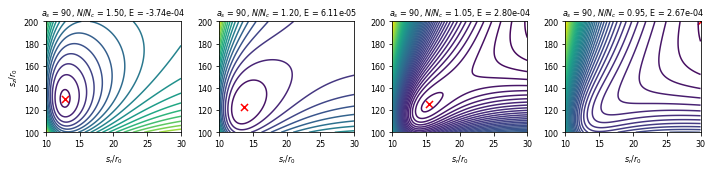

In [8]:
import numpy as np
import matplotlib.pyplot as plt

n_critical = 2366
ratios = [1.5, 1.2, 1.05, 0.95]

n_counturs = [20, 20, 100, 50]
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 2.5))

ng = 100
sr_range = np.linspace(10, 30, ng)
sz_range = np.linspace(100, 200, ng)
# make meshgrid
sr, sz = np.meshgrid(sr_range, sz_range)


for i, n_critical_ratio in enumerate(ratios):
    nparticles = n_critical * n_critical_ratio
    alpha = 2 * np.pi * (a_s / r_0)
    beta = func_beta(a_s, *popt_beta)
    gamma = func_gamma(a_s, *popt_gamma)
    
    en = en_per_particle(sr, sz, nparticles, alpha, beta, gamma, include_ho=False)
    en[en > 0.01] = 0
    
    out = get_optimal_sr_sz(alpha, beta, gamma, nparticles=nparticles, sr_range=[10,30], sz_range=[100,200])
    print(n_critical_ratio, out)

    
    
    ax = axes[i]
    
    # Add the X marker at the location
    ax.scatter(out['sr'], out['sz'], marker='x', color='red', s=50)
    
    ax.contour(sr, sz, en, n_counturs[i])
    ax.set_xlabel(r'$s_r/r_0$', fontsize=8)
    if i == 0:
        ax.set_ylabel(r'$s_z/r_0$', fontsize=8)
    ax.set_title(r'$a_s$' + f" = 90, " + r'$N/N_c$' + f" = {nparticles/n_critical:.2f}, " + f"E = {out['en_0']:.2e}", fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)

plt.tight_layout()
plt.show()


# save as "paper-figures/energy-landscape-90.pdf"
fig.savefig("paper-figures/energy-landscape-90.pdf", bbox_inches='tight')
